In [1]:
import torch, detectron2 

In [2]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

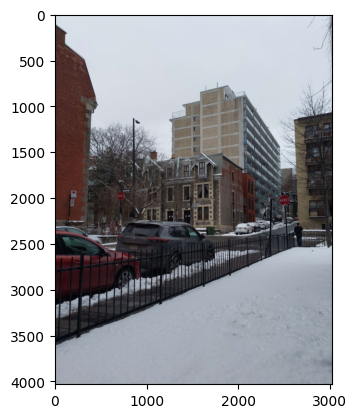

In [4]:
img = cv2.imread("/home/james/Documents/VS/detect-a-scroll/test_data/mtl_street_scene.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [5]:
cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

[03/30 22:15:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


/home/james/anaconda3/envs/detectron2/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 2,  0,  2,  2,  2,  0,  2,  2,  2,  2, 11], device='cuda:0')
Boxes(tensor([[   0.0000, 2294.3682,  931.5198, 3140.3684],
        [2598.8394, 2276.8906, 2695.4521, 2539.0144],
        [ 646.8956, 2241.1294, 1736.1698, 2852.5283],
        [1955.8148, 2274.0312, 2156.2932, 2404.2837],
        [2186.2905, 2242.9800, 2326.1528, 2348.8286],
        [ 592.5176, 2235.4089,  649.3793, 2407.5298],
        [2587.1450, 2215.1047, 2649.8999, 2257.1746],
        [   0.0000, 2309.9893,  347.2288, 2418.1501],
        [2090.1616, 2270.5488, 2245.1172, 2379.6521],
        [2485.3757, 2216.9658, 2587.5010, 2286.6147],
        [2435.7522, 1971.6868, 2551.3098, 2087.5583]], device='cuda:0'))


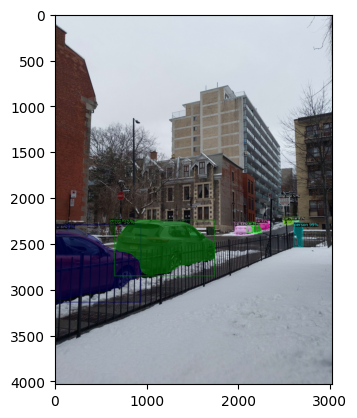

In [7]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

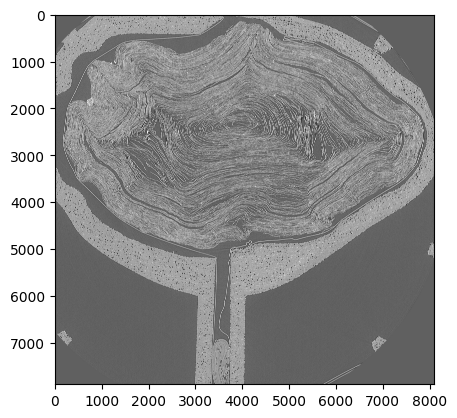

In [8]:
scroll_img = cv2.imread("/home/james/Documents/VS/detect-a-scroll/test_data/Scroll_mask_data_to_annotate/01500.jpg")
scroll_img = cv2.cvtColor(scroll_img, cv2.COLOR_BGR2RGB)
plt.imshow(scroll_img)

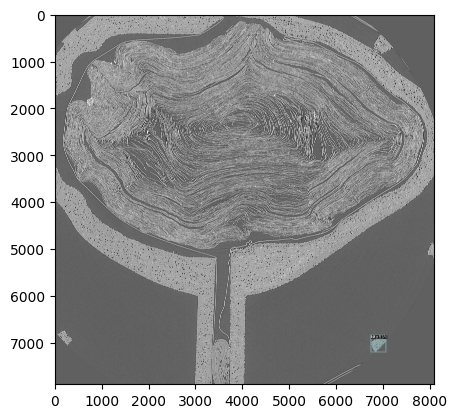

In [9]:

sci_outputs = predictor(scroll_img)
sci_v = Visualizer(scroll_img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
plt.imshow(sci_out.get_image()[:, :, ::-1])

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/home/james/Documents/VS/detect-a-scroll/test_data/Scroll_mask_data_to_annotate/output.json", 
                        "/home/james/Documents/VS/detect-a-scroll/test_data/Scroll_mask_data_to_annotate/")

# register_coco_instances("my_dataset_train", {}, "/home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/train/train.json", "/home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/train")
# register_coco_instances("my_dataset_val", {}, "/home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/val/val.json", "/home/james/Documents/VS/detect-a-scroll/test_data/finetune_detect-a-scroll/val")

In [11]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
# val_metadata = MetadataCatalog.get("my_dataset_val")
# val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

WARNING [03/30 22:15:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/30 22:15:22 d2.data.datasets.coco]: Loaded 53 images in COCO format from /home/james/Documents/VS/detect-a-scroll/test_data/Scroll_mask_data_to_annotate/output.json


In [12]:
# Visualize some random samples
# for d in random.sample(train_dataset_dicts, 15):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1])
#     plt.title(d["file_name"])  # Add the file name as the title
    
#     plt.show()

# Visualize all samples
# for d in train_dataset_dicts:
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1])
#     plt.title(d["file_name"])  # Add the file name as the title
    
#     plt.show()

In [13]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/home/james/Documents/VS/detect-a-scroll/checkpoints"
model_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
# model_path = "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(model_path))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 30
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_path)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 3  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 50000  # 3000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 class.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.
# Set the checkpoint period
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=True) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[03/30 22:15:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [14]:
trainer.train() #Start the training process

[03/30 22:15:22 d2.engine.train_loop]: Starting training from iteration 20000
ERROR [03/30 22:15:27 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/james/anaconda3/envs/detectron2/lib/python3.12/site-packages/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/home/james/anaconda3/envs/detectron2/lib/python3.12/site-packages/detectron2/engine/defaults.py", line 496, in run_step
    self._trainer.run_step()
  File "/home/james/anaconda3/envs/detectron2/lib/python3.12/site-packages/detectron2/engine/train_loop.py", line 310, in run_step
    loss_dict = self.model(data)
                ^^^^^^^^^^^^^^^^
  File "/home/james/anaconda3/envs/detectron2/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/james/anaconda3/envs/detectron2/lib/python3.12/site-packages/torch/nn/mod

OutOfMemoryError: CUDA out of memory. Tried to allocate 300.00 MiB. GPU 0 has a total capacity of 23.43 GiB of which 153.12 MiB is free. Process 1056772 has 1.15 GiB memory in use. Including non-PyTorch memory, this process has 22.11 GiB memory in use. Of the allocated memory 21.52 GiB is allocated by PyTorch, and 134.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

import yaml
# Save the configuration to a config.yaml files
# Save the configuration to a config.yaml file
config_yaml_path = "/home/james/Documents/VS/detect-a-scroll/demo/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [ ]:

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/30 20:58:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/james/Documents/VS/detect-a-scroll/checkpoints/model_final.pth ...


In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

NameError: name 'val_dataset_dicts' is not defined

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:
new_im = cv2.imread("/home/james/Documents/VS/detect-a-scroll/test_data/00250.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.imshow(out.get_image()[:, :, ::-1])